Task:
    The website launched an A/B test in order to increase income. The data set contains raw data collected from the test.
    Analyze the results of this test to see if the change of services has positive impact on revenue. 

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.utils import resample
from scipy.stats import shapiro 
from scipy.stats import levene
from scipy.stats import mannwhitneyu 

In [87]:
df=pd.read_csv(r'C:\Users\jessi\OneDrive\Desktop\AB_test_datesets\AB_Test_Results.csv')

# Exploratory Data Analysis

In [88]:
df.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


In [89]:
df.tail()

,USER_ID,VARIANT_NAME,REVENUE
9995,1981,control,0.0
9996,502,variant,0.0
9997,9214,variant,0.0
9998,7741,control,0.0
9999,9468,control,0.0


In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [91]:
df.describe()

,USER_ID,REVENUE
count,10000.000000,10000.000000
mean,4981.080200,0.099447
std,2890.590115,2.318529
min,2.000000,0.000000
25%,2468.750000,0.000000
50%,4962.000000,0.000000
75%,7511.500000,0.000000
max,10000.000000,196.010000


In [92]:
#count for each variant
df['VARIANT_NAME'].value_counts()

variant    5016
control    4984
Name: VARIANT_NAME, dtype: int64

In [93]:
#count unique users
df['USER_ID'].nunique()

6324

In [94]:
#check duplicated users
duplicate_check=df.groupby('USER_ID')['VARIANT_NAME'].nunique().value_counts()
duplicate_check

1    4783
2    1541
Name: VARIANT_NAME, dtype: int64

In [95]:
#see duplicated users in portion
duplicate_check/duplicate_check.sum()

1    0.756325
2    0.243675
Name: VARIANT_NAME, dtype: float64

In [96]:
# 24% of user_id appeared in both variants in our data set, we need to remove these duplicates to make our data more clean and accurate. 
duplicates=df.groupby('USER_ID')['VARIANT_NAME'].nunique()>1 
duplicates=duplicates[duplicates].index
df=df[~df['USER_ID'].isin(duplicates)]
df

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
4,6174,variant,0.0
5,2380,variant,0.0
7,9168,control,0.0
9,7548,control,0.0
...,...,...,...
9993,2400,variant,0.0
9994,3129,control,0.0
9996,502,variant,0.0
9998,7741,control,0.0


In [97]:
#double check if the data set has cleaned 
df.groupby('USER_ID')['VARIANT_NAME'].nunique().value_counts()==duplicate_check.iloc[0]

1    True
Name: VARIANT_NAME, dtype: bool

We've noticed there is a huge different between the max value and mean value/std value in Revenue, Let's plot and sort the data set to see if there is any outliers. 

<Axes: xlabel='VARIANT_NAME', ylabel='REVENUE'>

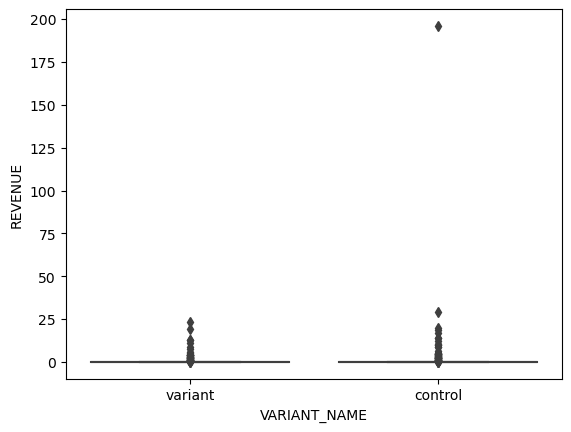

In [98]:
#plot the data set 
sns.boxplot(data=df, x='VARIANT_NAME',y='REVENUE')

In [99]:
#sort the data by revenue desc
df.sort_values(by='REVENUE',ascending=False)

,USER_ID,VARIANT_NAME,REVENUE
1437,3342,control,196.01
8168,2166,control,29.32
2482,7356,variant,23.04
6412,1053,control,20.07
5217,3684,variant,19.47
...,...,...,...
3366,1189,control,0.00
3363,2051,variant,0.00
3362,3276,variant,0.00
3360,1608,variant,0.00


There is only 1 extreme value, so we are going to remove it. 

In [100]:
#remove 1 outlier
df=df[df['USER_ID']!= 3342]

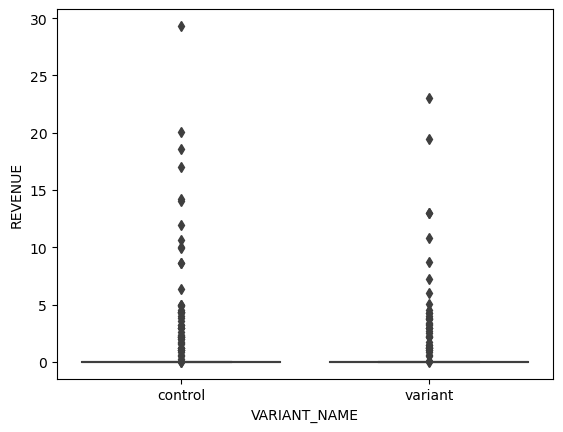

In [118]:
#plot the data set after removing the outlier

sns.boxplot(data=df, x='VARIANT_NAME',y='REVENUE')

plt.show()

In [102]:
#check for duplicated user_id in 0 revenue and positive revenue
df[df['REVENUE']==0]['USER_ID'].isin(df[df['REVENUE']!=0]['USER_ID']).sum()

52

In [103]:
#sum revenues for each user
df= df.groupby(by=['USER_ID','VARIANT_NAME']).sum().reset_index()

In [119]:
#check again for duplicated user_id in 0 revenue and positive revenue
df[df['REVENUE']==0]['USER_ID'].isin(df[df['REVENUE']!=0]['USER_ID']).sum()

0

# Statistical Analysis 

Check standard statistical analysis for all users and paid users

In [105]:
#All users 
df.groupby(by='VARIANT_NAME').agg({'USER_ID':'nunique',
                                    'REVENUE':
                                            ['count','sum','mean','median','std']})


USER_ID REVENUE                                   
             nunique   count     sum      mean median       std
VARIANT_NAME                                                   
control         2389    2389  274.55  0.114923    0.0  1.162495
variant         2393    2393  179.32  0.074935    0.0  0.858207

In [116]:
#Paid users 
df[df['REVENUE']>0].groupby(by='VARIANT_NAME').agg({'USER_ID':'nunique',
                                    'REVENUE':
                                            ['count','sum','mean','median','std']})



USER_ID REVENUE                                   
             nunique   count     sum      mean median       std
VARIANT_NAME                                                   
control           53      53  274.55  5.180189   2.99  5.942771
variant           42      42  179.32  4.269524   2.97  4.962253

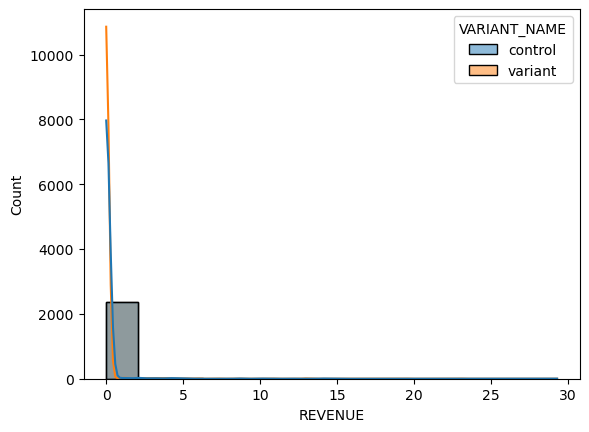

In [123]:
#check the data distribution for all users
sns.histplot(data=df, x='REVENUE',hue='VARIANT_NAME',kde=True)

plt.show()

In [108]:
#Graph shows our data set is not normal distrubuted, we will use Shapiro-Wilk test to confirm.
    #H0: Data is normally distributed. 
    #H1: Data is not normally distributed.
    
for i in ['variant','control']:
        p = shapiro(df.loc[df.VARIANT_NAME==i, 'REVENUE'])[1]
        if p > 0.05:
            print(f"Variant: {i} is normal distribution")
        else:
            print(f"Variant: {i} is not normal distribution")

Variant: variant is not normal distribution
Variant: control is not normal distribution


In [109]:
#Check data for homogeneity of variance,using Levene'test. 
    #H0: The variant and control group has the same variance 
    #H1: The variant and control group do not have the same variance
    
control = df[df['VARIANT_NAME']=='control']
variant = df[df['VARIANT_NAME']=='variant']
levene(control['REVENUE'][control['REVENUE']>=0],
        variant['REVENUE'][variant['REVENUE']>=0])

LeveneResult(statistic=1.8315496300786236, pvalue=0.17600861562570844)

Since the p value > 0.05, we can accept the H0 and know that our data set have the same variances for both groups. 

In [110]:
#Check if the data population Median is the same. 
    #H0: Variant and control group have the same population shape and there is no difference between the two median.
    #H1: Variant and control group do not have the same population shape and do not have same median.
mannwhitneyu(variant['REVENUE'], control['REVENUE'])

MannwhitneyuResult(statistic=2845109.0, pvalue=0.24799555106821947)

Since the p value > 0.05, we can accept the H0 and know that our data has the same population shape and there is no difference between two medians. 

In [111]:
#Check if there is difference between the mean of two groups using Bootstrap .  
    #Confidence Interval= 95%

variant=df[df['VARIANT_NAME']=='variant']['REVENUE']
control=df[df['VARIANT_NAME']=='control']['REVENUE']

In [112]:
variant_bootstrap=[]
for i in range(10000):
    np.random.seed(i)
    variant_bootstrap.append((resample(variant)))
    
variant_bootstrap_mean=np.mean(variant_bootstrap, axis=1)
variant_bootstrap_mean

array([0.07119097, 0.07910573, 0.07979106, ..., 0.05484747, 0.06765148,
       0.11359799])

In [113]:
control_bootstrap=[]
for i in range(10000):
    np.random.seed(i)
    control_bootstrap.append((resample(control)))
    
control_bootstrap_mean=np.mean(control_bootstrap, axis=1)
control_bootstrap_mean

array([0.10843031, 0.08146086, 0.12675178, ..., 0.08847635, 0.09521976,
       0.09601925])

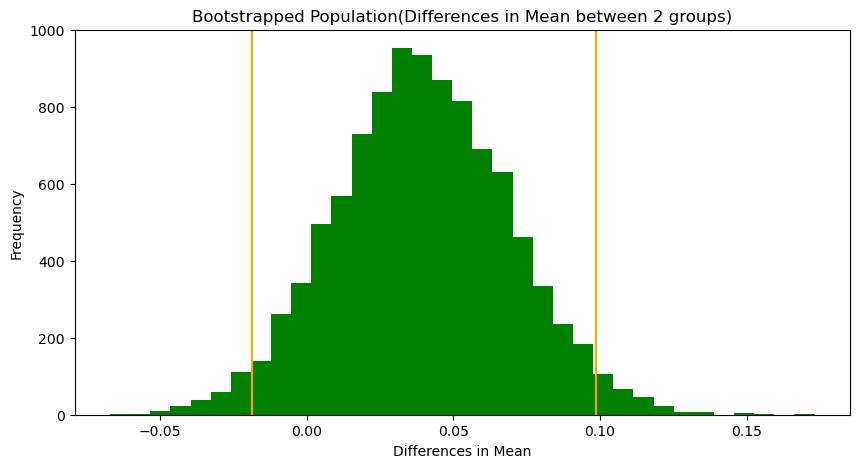

Lower Bound: -0.018783776045907575
Upper Bound: 0.09855595025920617


In [114]:
mean_diff=control_bootstrap_mean-variant_bootstrap_mean
lower_bound=np.percentile(mean_diff, 2.5)
upper_bound=np.percentile(mean_diff, 97.5)

fig=plt.figure(figsize=(10,5))
ax=plt.hist(mean_diff, bins=35,color='green')

plt.xlabel('Differences in Mean')
plt.ylabel('Frequency')
plt.axvline(lower_bound, color='orange')
plt.axvline(upper_bound,color='orange')
plt.title('Bootstrapped Population(Differences in Mean between 2 groups)')
plt.show()

print('Lower Bound: {}'.format(lower_bound))
print('Upper Bound: {}'.format(upper_bound))

With 95% confidence level, the differences in mean between 2 groups is in range of (-0.019 , 0.079), so we can say that there is no difference between 2 groups. 

# Conclusion 

There is no statistical difference on the revenue of the variant and control groups.